<a href="https://colab.research.google.com/github/ordevoir/MLDL/blob/master/DL_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
# from tensorflow import keras
from IPython.display import clear_output

tf.__version__

'2.13.0'

In [2]:
import matplotlib.pyplot as plt

# Определим дефолтные значения для визуализации
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# Загрузка данных

[`tf.keras.datasets`](https://keras.io/api/datasets/) содержит набор функций для загрузки популярных датасетов. Fashion MNIST можно загрузить функцией `load_data()` из модуля [`fashion_mnist`](https://keras.io/api/datasets/fashion_mnist/). Функция `load_data()` возвращает кортеж, содержащий пару кортежей. Первый содержит два массива (`X`, `y`) тренировочных данных, а второй – два массива тестовых данных.

In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist

# всего картинок 60000, размер каждой 28x28
print(f"{X_train_full.shape = }\n{X_train_full.dtype = }")

X_train_full.shape = (60000, 28, 28)
X_train_full.dtype = dtype('uint8')


label: 2


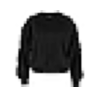

In [11]:
plt.figure(figsize=(1, 1))
plt.imshow(X_train_full[7], cmap='Greys')
plt.axis(False)
print("label:", y_train_full[7])

Данные уже разделены на тренировочный (60000 изображений) и тестовый (10000 изображений) наборы, однако полезно будет дополнительно разбить тренировочный набор, чтобы получить валидационный набор данных. 

Масштабируем иходные данные, лежащие в интервале $[0, 255]$ так, чтобы значения лежали в диапазоне $(0, 1)$.

In [6]:
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

X_train, X_valid, X_test =X_train / 255., X_valid / 255., X_test / 255.

Всего классов 10, составим список имен классов:

In [8]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

y_train[0], class_names[y_train[0]]     # выведем класс первого образца

(9, 'Ankle boot')

# Составление модели через Sequential API

## Создание модели
Создается объект класса `Sequential`, затем методом `add()` последовательно добавляются слои. 

Keras присваивает **имена** слоям. Каждый слой в модели должен иметь уникальное имя. Более того, его глобальное имя в сессии должно быть уникальным. Это позволяет объединять несколько моделей в одну модель. Имя слоя обычно состоит из типа слоя и номера (например, `dense_5`), поэтому при генерации имен используются глобальные счетчики имен. Глобальное состояние хранится в сеансе (Keras session), который может быть сброшен функцией `tf.keras.backend.clear_session()`. 

In [13]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=[28, 28]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(300, activation="relu"))
model.add(tf.keras.layers.Dense(100, activation="relu"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

Первым слоем будет входной слой `InputLayer`. В конструктор передаем форму `input_shape`. Форма нужна для того, чтобы Keras смог определить форму матрицы весов первого скрытого слоя.

Второй слой `Flatten` примет двумерный массив и превратит в одномерный (как при `reshape(-1, 1)`). Этот слой не имеет параметров, поэтому играет роль простого препроцессора.

Слои `Dense` подразумевают полносвязность, в скобках указаны: число нейронов в слое (`units`) и [функция активации](https://keras.io/activations/) (`activatin`). Последний слой будет содержать 10 нейронов (так как всего классов $K=10$) с функцией активации `softmax` так как классы являются эксклюзивными.

**Многопеременная логистическая функция** (*softmax*) $\sigma : \mathbb R^K \to (0, 1)^K$ переводит вектор $K$ вещественных чисел $\mathbf s$ в распределение вероятностей $K$ возможных исходов ($ \sum \sigma_i = 1$) и является обобщением логистической функции на многомерный случай. Пусть $\mathbf s$ представляет собой $K$-мерный вектор (взвешенные суммы $s_i$ нейронов слоя). Тогда вероятность $i$-го исхода (выход $i$-го нейрона) определяется формулой:
$$
\sigma_i (\mathbf s) = \frac{e^{s_i}}{\sum_{j=1}^K e^{s_j}}
$$

Альтернативный способ – вместо добавления слоев после создания объекта `Sequential`, можно передать список слоев в конструктор. В данной архитектуре можно пропустить `InputLayer` и вместо него просто задать `input_shape` в слое `Flatten`.

In [16]:
# очистим сессию, чтобы сбросить счетчик имен
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
    # tf.keras.layers.InputLayer(input_shape=[28, 28]),
    # tf.keras.layers.Flatten(),
    tf.keras.layers.Flatten(input_shape=[28, 28]),       # первый слой
    tf.keras.layers.Dense(300, activation='relu'),       # скрытые
    tf.keras.layers.Dense(100, activation='relu'),       # слои
    tf.keras.layers.Dense(10, activation='softmax')      # выходной слой
])

## Информация о модели

Метод `summary()` выводит все слои модели, включая имена слоев (автоматически сгенерированные при их создании), форму выхода (`None` означает, что размер партии может быть любым) и количество параметров. Так же выводит общее число параметров (тренируемых и не тренируемых).

In [9]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 300)               235500    
                                                                 
 dense_4 (Dense)             (None, 100)               30100     
                                                                 
 dense_5 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266610 (1.02 MB)
Trainable params: 266610 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Доступ к слоям модели

Можно получить список (объектов) слоев, получить доступ к слою по индексу или по имени (методы `layers()` и `get_layer()`):

In [10]:
print(model.layers)                     # список слоев
hidden_1 = model.layers[1]              # получение слоя по индексу
hidden_2 = model.get_layer('dense_3')   # получения слоя по имени
print(type(hidden_1))
print('names:', hidden_1.name, hidden_2.name)

[<keras.src.layers.reshaping.flatten.Flatten object at 0x000001707BA7CBD0>, <keras.src.layers.core.dense.Dense object at 0x00000170752C7450>, <keras.src.layers.core.dense.Dense object at 0x00000170752C5810>, <keras.src.layers.core.dense.Dense object at 0x00000170752B2C90>]
<class 'keras.src.layers.core.dense.Dense'>
names: dense_3 dense_3


## Параметры слоя

Можно получить и установить значения параметров слоя методами `get_wieghts()` и `set_weights()`

In [11]:
weights, baises = hidden_1.get_weights() # получение значений
print(weights.shape, baises.shape)
print(baises.dtype)

(784, 300) (300,)
float32


По умолчанию веса инициализированы рандомно, а смещения – нулями. Если нужно иначе инициализировать параметры, то можно установить значения `kernel_initializer` и `bais_initializer` при создании слоя (kernel – другое название для матрицы связей (весов)). Подробнее <a href="https://keras.io/initializers/">здесь</a>.

In [12]:
print(f"{weights.shape = },\n{baises.shape = }")
print('weights:\n', weights[:4, :4])
print('baises:\n', baises[:10])

weights.shape = (784, 300),
baises.shape = (300,)
weights:
 [[ 0.02286225  0.00481734 -0.05747168  0.01301109]
 [ 0.02562317  0.06919216 -0.04737694  0.07125536]
 [ 0.03873138  0.0483441   0.03926891  0.0550178 ]
 [ 0.05738507  0.04130226 -0.05428929 -0.00567409]]
baises:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## Компиляция модели

После того, как модель создана, нужно вызвать метод `compile()`, указать <a href="https://keras.io/losses">функцию потерь</a>, и <a href="https://keras.io/optimizers">метод оптимизации</a>; также можно задать список дополнительных <a href="https://keras.io/metrics">метрик</a>, которые нужно попутно вычислять:

In [13]:
model.compile(loss="sparse_categorical_crossentropy",
             optimizer="sgd", metrics=["accuracy"])

Выражение `loss="sparse_categorical_crossentropy"` равносильно выражению
`loss=keras.losses.sparse_categorical_crossentropy`.<br>
Выражение
`optimizer="sgd"` равносильно выражению `optimizer=keras.optimizers.SGD()`
(Stochastic Gradient Descen).
Выражение `"accuracy"` равносильно выражению `keras.metrics.sparse_categorical_accuracy`.<br>
https://keras.io/losses<br>
https://keras.io/optimizers<br>
https://keras.io/metrics

Здесь мы используем sparse (разреженную) categorical crossentropy,
а не просто categorical crossentropy в силу того, что метка данных
представляет собой целое число от 0 до 9, в то время как на выходе
нейронной сети получается 10-мерный вектор. Для того, чтобы можно
было бы сравнивать выходной вектор и метку, необходимо представить
метки в виде десятимерных one-hot vectors, который для метки 3 будет
`[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]`.<br>
Если бы метки изначально были бы представлены в виде one-hot vectors,
то следовало бы использовать `categorical_crossentropy`.<br>
Если бы использовалась бинарная классификация, то на выходном слое
вместо функции активации softmax использовалась сигмоида, и в качестве
функции потерь стоило бы использовать `binary_crossentropy`.

При использовании метода оптимизации SGD важно настраивать скорость
обучения (learning rate) `optimizer=keras.optimizers.SGD(learning_rate=0.1)`,
`optimizer="sgd"` по умолчанию устанавливается `learning_rate=0.01`.

## Обучение модели на задаче классификации

Для обучения модели используется метод `fit()`, который возвращает объект класса `History`, который содержит данные об истории обучения.

In [14]:
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid))

Epoch 1/5


1719/1719 [==============================] - 4s 2ms/step - loss: 0.7157 - accuracy: 0.7655 - val_loss: 0.5239 - val_accuracy: 0.8236
Epoch 2/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4910 - accuracy: 0.8287 - val_loss: 0.4470 - val_accuracy: 0.8458
Epoch 3/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4457 - accuracy: 0.8445 - val_loss: 0.4163 - val_accuracy: 0.8572
Epoch 4/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4175 - accuracy: 0.8548 - val_loss: 0.3941 - val_accuracy: 0.8672
Epoch 5/5
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3977 - accuracy: 0.8600 - val_loss: 0.3835 - val_accuracy: 0.8656


Вместо того, чтобы передавать данные для валидации используя аргумент
`validation_data`, можно установить значение `validation_split=0.1`, при
котором keras сам будет использовать последние 10% тренировочных данных в качестве валидационных данных.<br>

Если есть перекос в данных, при котором некоторые классы представлены в большем количестве, можно установить веса для классов `class_weight`, при котором менее представленные классы будут иметь больший вес. Эти веса будут учтены при подсчете функции потерь. Также можно задать веса для образцов `sample_weight`, если одна группа образцов должна быть более влиятельной на обучение, чем другая. Если для образца заданы оба значения `class_weight` и `sample_weight`, то keras перемножит их.<br>
Можно указать также значение параметра `batch_size` (по умолчанию 32)

Поле `history` объекта класса `History` представляет собой словарь, содержащий метрики, собранные в ходе обучения:

In [15]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

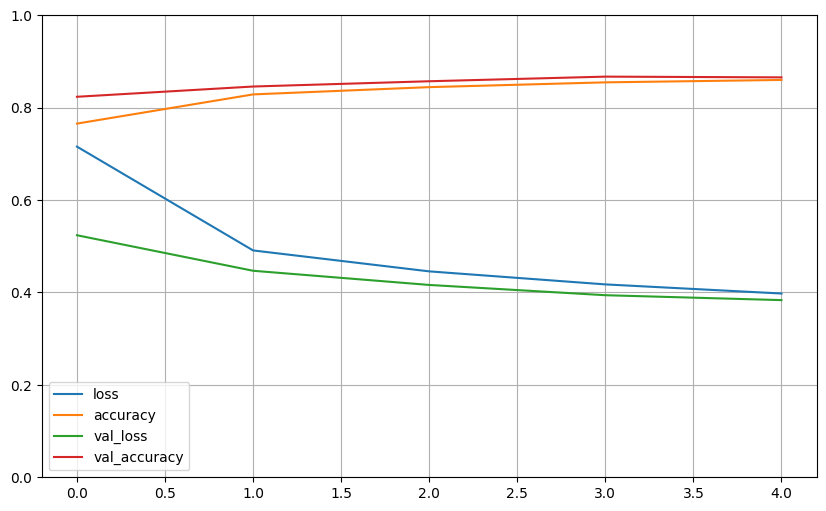

In [16]:
pd.DataFrame(history.history).plot(figsize=(10, 6))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## Оценка на тестовом наборе

Для оценки модели на тестовом наборе можно использовать метод `evaluate()`, который возвращает список, содержаший loss и accuracy.

In [17]:
loss, accuracy = model.evaluate(X_test, y_test, batch_size=32)
print(f"{loss = }\n{accuracy = }")

313/313 [==============================] - 0s 1ms/step - loss: 0.4231 - accuracy: 0.8490
loss = 0.42311981320381165
accuracy = 0.8489999771118164


Используем первые образцы тестовых данных. Для получения вероятностей прогнозирования используется метод `predict()`.

In [18]:
X_new = X_test[:7]
y_probabilities = model.predict(X_new)
print(y_probabilities.round(2))

1/1 [==============================] - 0s 87ms/step
[[0.   0.   0.   0.   0.   0.07 0.   0.19 0.01 0.74]
 [0.   0.   0.99 0.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.13 0.   0.18 0.01 0.04 0.   0.63 0.   0.01 0.  ]
 [0.01 0.98 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.02 0.   0.05 0.   0.83 0.   0.09 0.   0.01 0.  ]]


Для получения меток классов на основе прогнозов следует использовать функцию `argmax()` из Numpy с параметром `axis=1`.

In [19]:
y_pred = np.argmax(y_probabilities, axis=1)
print(y_pred)

[9 2 1 1 6 1 4]


Название соответствующих классов для полученных меток `y_pred` можно получить используя определенный раннее список `class_names`:

In [20]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser', 'Trouser', 'Shirt', 'Trouser',
       'Coat'], dtype='<U11')

## Обучение модели на задаче регрессии

In [21]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data,
                                                              housing.target,
                                                              random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full,
                                                      y_train_full,
                                                      random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

Составим и скомпилируем двуслойную модель, в которой последний слой будет содержать 1 нейрон без функции активации. В качестве функции потерь будет использована MSE:

In [22]:
modelReg = keras.models.Sequential([
    keras.layers.Dense(10, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])

print(X_train.shape)
print(X_train.shape[1])
print(X_train.shape[1:])
# двоеточие здесь приведет к тому, что будет возвращен кортеж, а не число:

(11610, 8)
8
(8,)


Обучение модели

In [23]:
modelReg.compile(loss="mean_squared_error", optimizer="sgd")
historyReg = modelReg.fit(X_train, y_train, epochs=20, validation_split=0.1)
clear_output()

Оценка

In [24]:
print("train loss:", historyReg.history['loss'][-1])      # вывод итоговых
print("valid loss:", historyReg.history['val_loss'][-1])  # значений потерь

train loss: 0.3730415403842926
valid loss: 0.4250633716583252


Метод `evaluate()` в случае регрессии возвращает только loss (в данном случае это MSE).

In [25]:
mse_test = modelReg.evaluate(X_test, y_test)
mse_test

 57/162 [=========>....................] - ETA: 0s - loss: 0.3827

162/162 [==============================] - 0s 963us/step - loss: 0.3790


0.3789967894554138

Прогнозирование на трех образцах тестовой выбоки:

In [26]:
X_new = X_test[:3]
y_pred = modelReg.predict(X_new)
print(y_pred)
print(y_test[:3])

1/1 [==============================] - 0s 43ms/step
[[0.8812908]
 [1.69873  ]
 [4.048559 ]]
[0.477   0.458   5.00001]


In [27]:
historyReg.history.keys()

dict_keys(['loss', 'val_loss'])

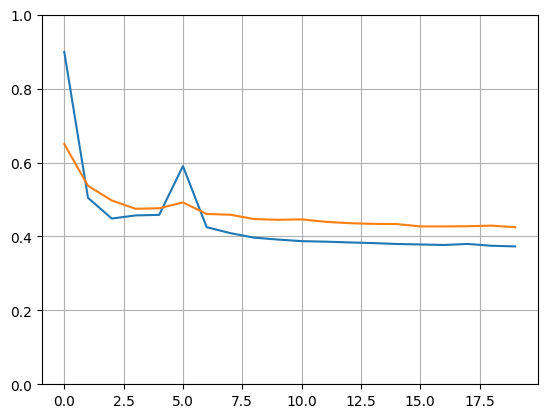

In [28]:
plt.plot(pd.DataFrame(historyReg.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

# Построение сложных моделей с использованием Functional API

Для построения нейронных сетей с более сложной топологией, Keras предоставляет Functional API. Составим нейронную сеть Wide & Deep, которая будет решать прдыдущую задачу по прогнозированию цен калифорнийских домов. Сеть будет содержать скрытые слои, но при этом *входной слой будет напрямую влиять на выходной слой*.

![](images/neural_network/Wide_deep_nn.png)

In [31]:
np.random.seed(42)
tf.random.set_seed(42)

Заметим, что слои вызываются как функции, которым передаются аргументом другие (входящие) слои, от того и название Functional API:

In [30]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden_1 = keras.layers.Dense(30, activation="relu")(input_)
hidden_2 = keras.layers.Dense(30, activation="relu")(hidden_1)
concat = keras.layers.Concatenate()([input_, hidden_2])
output = keras.layers.Dense(1)(concat)
# теперь создадим сам модель:
modelWD = keras.Model(inputs=[input_], outputs=[output])

Может потребуется передать часть признаков (`input_A`) скрытому слою, а другую часть (`input_B`) – напрямую к выходному слою.


![](images/neural_network/Handling_multiple_inputs.png)

In [ ]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden_1 = keras.layers.Dense(30, activation="relu")(input_B )
hidden_2 = keras.layers.Dense(30, activation="relu")(hidden_1)
concat = keras.layers.concatenate([input_A, hidden_2])
output = keras.layers.Dense(1, name="output")(concat)

mdl = keras.Model(inputs=[input_A, input_B], outputs=[output])

При вызове методов модели нужно указывать кортеж из входных данных (`X_train_A`, `X_train_B`), содержащий две группы данных соответствующих признаков.

`keras.layers.Concatenate()([a, b])` равносильно `keras.layers.concatenate([a, b])`

In [33]:
x = np.arange(20).reshape(2, 2, 5)
y = np.arange(20, 30).reshape(2, 1, 5)
tf.concat([x, y], axis=1) # <=> tf.keras.layers.concatenate([x, y], axis=1)

<tf.Tensor: shape=(2, 3, 5), dtype=int32, numpy=
array([[[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [20, 21, 22, 23, 24]],

       [[10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19],
        [25, 26, 27, 28, 29]]])>

Далее, после того как модель создана, все как обычно: компилирем модель, обучаем, оцениваем, делаем прогнозы. Заметим, что `"mse"` равносильно `"mean_squared_error"`. Создадим для этого соответствующие наборы данных `A` и `B`, каждый из которых содержит нужные подмножества призаков.

In [37]:
mdl.compile(loss="mse", optimizer="sgd")

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = mdl.fit((X_train_A, X_train_B), y_train, epochs=20,
                    validation_data=((X_valid_A, X_valid_B), y_valid))
mse_test = mdl.evaluate((X_test_A, X_test_B), y_test)
y_pred = mdl.predict((X_new_A, X_new_B))
clear_output()

В некоторых случаях может потребоваться и множественный вывод. Возможно, сама задача требует такого решения, например, требуется локализовать и классифицировать объект на картинке. Здесь содержится и регрессия и классификация. Может потребоваться дополнительный (*auxiliary*) выход для регуляризации.

![](images/neural_network/Handling_multiple_outputs.png)

Для того, чтобы добавить дополнительный выход, достаточно присоединить его к подходящему слою и добавить в список выходов модели.

In [34]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden_1 = keras.layers.Dense(30, activation="relu")(input_B )
hidden_2 = keras.layers.Dense(30, activation="relu")(hidden_1)
concat = keras.layers.concatenate([input_A, hidden_2])
output = keras.layers.Dense(1, name="output")(concat)
aux = keras.layers.Dense(1, name='aux')(hidden_2)

mdl = keras.Model(inputs=[input_A, input_B], outputs=[output, aux])

Каждый выход нуждается в своей функции потерь. Следовательно, при компиляции модели следует передать список этих функций потерь. Если же мы передаем одну функцию потерь, то Keras будет считать, что одна и та же функция используется для свех выходов. Для того, чтобы на обучение сети влияли сильней ошибки на главном выходе, чем ошибки на дополнительном выходе, можно указать соответствующие веса влияния в праметре `loss_weight`

In [35]:
mdl.compile(loss=['mse', 'mse'], loss_weights=[0.9, 0.1], optimizer='sgd')

При обучении модели необходимо передать метки для обоих выходов. В данном случае глвный выход и дополнительный выход должны прогнозировать одну и ту же вещь, так что им следует передать одни и те же метки. Так что вместо передачи `y_train` мы должны передать `(y_train, y_train)`. То же касается и валидационных и тестовых данных.

In [38]:
history = mdl.fit(
    [X_train_A, X_train_B], [y_train, y_train], epochs=20,
    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid])
)
clear_output()

При оценке модели (`evaluate()`) Keras будет возвращать как полную ошибку, так и частные. А метод `predict()` будет возвращать прогнозы для каждого выхода.

In [40]:
total_loss, main_loss, aux_loss = mdl.evaluate(
    [X_test_A, X_test_B], [y_test, y_test]
)
y_pred_main, y_pred_aux = mdl.predict([X_new_A, X_new_B])

print(f"\n{total_loss = }\n{main_loss  = }\n{aux_loss   = }")
print(f"\n{y_pred_main = }\n{y_pred_aux  = }")

1/1 [==============================] - 0s 18ms/step

total_loss = 0.7016591429710388
main_loss  = 0.32214221358299255
aux_loss   = 0.3795167803764343

y_pred_main = array([[0.5359593],
       [1.3736318],
       [4.1079097]], dtype=float32)
y_pred_aux  = array([[0.6978617],
       [1.3102751],
       [4.045531 ]], dtype=float32)


# Построение гибких динамических моделей с использованием Subclassing API

Sequential API и the Functional API являются деклоративными: сначала декларируется, какие слои будут использованы и как они должны быть соединены, и только потом можно начать передавать в модель некоторые данные. Преимуществом такого подхода является возможность легкого сохранения модели, клонирования и распространения; его структура может быть отображена и проанализирована. Keras может проинспектировать архитектуру и выявить ошибки еще до начала обучения. Так же такую модель удобно отлаживать благодаря тому, что модель в целом представляет собой статичный граф слоев. Обратная сторона этого метода – статичность. Некоторые модели включают циклы, изменчивые формы, условные ветвления и другие динамические свойства. Для таких случаев, или просто для более императивного стиля программирования, предусмотрен Subclassing API.<br>
Создается дочерний класс, класса `Model`, в конструкторе которого создаются слои, а в методе `call()` производятся необходимые вычисления. Таким образом, создание слоев и их использование разделено. В отличие от Functional API мы здесь не создавали входные слои. Вместо этого мы передаем входные данные как аргумент в метод `call()`.<br>
Есть один недостаток этого подхода: архитектура сети скрыта в методе `call()`, так что Keras не может проинспектировать его. Это увеличивает риск ошибок. Если нет необходимости, лучше обойтись Sequential API или Functional API.

In [45]:

class WideAndDeepModel(keras.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs) # передаем в конструктор суперкласса прочие аргументы
        self.hidden_1 = keras.layers.Dense(units, activation=activation)
        self.hidden_2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)

    def call(self, inputs):
        input_A, input_B = inputs
        hidden_1 = self.hidden_1(input_B)
        hidden_2 = self.hidden_2(hidden_1)
        concat = keras.layers.concatenate([input_A, hidden_2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden_2)
        return main_output, aux_output

modelSub = WideAndDeepModel()

Сами модели Keras могут быть использованы как слои, что делает возможным комбинирование моделей для построения сложных архитектур.

# Сохранение и загрузка модели

In [50]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
clear_output()
mse_test = model.evaluate(X_test, y_test)

162/162 [==============================] - 0s 777us/step - loss: 0.4217


Сохранение в виде HDF5 файла:

In [42]:
model.save('model.h5')
model = keras.models.load_model('model.h5')

c:\Users\ordevoir\miniconda3\envs\tf\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Сохранение в виде файла keras:

In [47]:
model.save('model.keras')
model = keras.models.load_model('model.keras')

Это работает только при использованиии Sequential API или the Functional API но не с Subclassing API. Можно использовать `save_weights()` и `load_weights()` для сохранения и загрузки параметров модели, но все остальное придется сохранять и загружать самостоятельно.

# Использование <a href="https://keras.io/api/callbacks/">Callbacks</a>
Callback представляет собой объект, который может производить некоторые действия на различных этапах обучения. Callbacks могут вызываться перед стартом или завершением обучения, а так же в начале (или в конце) каждой эпохи или партии и тд.

При длительной тренировке больших данных может подтребоваться сохранение не только самой модели после обучения, но и сохранение **контрольных точек** (*checkpoints*) в процессе обучения, чтобы не потерять все в случае сбоев компьютера. Может возникнуть необходимость сохранять логи TensorBoard после каждой партии для мониторинга метрик. Так же callback может быть полезен для ранней остановки (early stopping) или learging rate scheduling (последнее рассмотренно в файле Deep NN).

Keras предоставляет некоторое <a href="https://keras.io/api/callbacks/">множество callbacks</a> в модуле `keras.callbacks`. Все эти классы наследуются от класса `Callbacks`, так что по нему можно <a href="https://keras.io/guides/writing_your_own_callbacks/">создать собственный класс callback</a>, как то сделано ниже.

Может быть создано неограниченное количество callbacks, и для их использования в тренировке нужно передать список объектов callbacks в аргумент `callbacks` метода `fit()`. Рассмотрим callback `ModelCheckpoint`, который сохраняет контрольные точки модели в конце каждой эпохи (по умолчанию). В конструктор класса передается имя файла. Также, если используются валидационные наборы в ходе обучения, то можно задать `save_best_only=True`, и тогда будет сохранена только модель с лучшей валидацией. В общем случае список callbacks может быть передан также и в методы `evaluate()` и `predict()` класса `keras.Model`.

In [58]:
checkpoint_cb = keras.callbacks.ModelCheckpoint('checkpoints',
                                                # save_weights_only=True,
                                                save_best_only=True)
history = model.fit(X_train, y_train, epochs=10,
                   validation_data=(X_valid, y_valid),
                   callbacks=[checkpoint_cb])
clear_output()

In [55]:
# теперь можно загрузить обратно в программу лучшую модель:
model = keras.models.load_model('keras_model.h5')

Callback `EarlyStopping` прерывает обучение, когда прекращается прогресс обучения на валидационных данных, и позволяет откатить к лучшей модели. Причем нет необходимости загружать обратно модель после обучения, если задать `restore_best_weights=True`, `EarlyStopping` будет отслеживать лучшие веса и присвоит их модели по завершении.

Можно использовать комбинацию этих двух рссмотренных callbacks. Это позволит сохранять контрольные точки модели (на случай, если вдруг произойдет сбой компьютера), а так же прервать обучение после того, как прогресс обучения прекратится (во избежание лишних затрат ресурсов).

In [56]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])
clear_output()
print(history.history['loss'][-1])
print(history.history['val_loss'][-1])

0.3378041684627533
0.32977283000946045


При необходимости в дополнительном контроле можно написать собственный класс коллбэк наследуя класс `keras.callbacks.Callback`. Создадим коллбэк, который показывает соотношение между валидационным и тренировочным потерями в ходе обучения (т.е. регистрировать переобучение).<br> Определим метод `on_epoch_end()`, который будет вызываться при завершении каждой эпохи. Также можно определить и методы `on_train_begin()`, `on_train_end()`, `on_epoch_begin()`, `on_batch_begin()`, and `on_batch_end()`. <br>
Коллбэки могут быть использованы также и при оценке модели и прогнозировании.<br>
Для `evaluate()` имена методов: `on_test_begin()`, `on_test_end()`, `on_test_batch_begin()`, `on_test_batch_end()`. <br>
Для `predict()` имена методов: `on_predict_begin()`, `on_pre dict_end()`, `on_predict_batch_begin()`, `on_predict_batch_end()`

In [ ]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print(f"\nval/train: {logs['val_loss'] / logs['loss']}")

display_ratio_cb = PrintValTrainRatioCallback()

history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb, display_ratio_cb])
clear_output()

Доступ к модели можно получить в объекте класса `Callback` через поле `self.model`, хотя мы не задаем это поле явно в создаваемом на базе `Callback` классе.
Когда происходит передача callback-объекта в метод модели `fit()`, происходит вызов метода callback-объекта `set_model()`. В этот метод передается экземпляр модели как аргумент, и метод который задает значение поля `self.model`. Для того, чтобы извлечь или установить значения в объектах tensorflow, используются функции `get_value()` и `set_value()` из модуля полезных функций `keras.backend`. Функция `get_value()` принимает тензор или переменную объекта tensorflow и возвращет массив или число NumPy. Функция `set_value()` устанавливает значение из объекта NumPy в тензор или переменную tensorflow. Первым аргументом принимает объект tensorflow, вторым – объект NumPy. Пример того, как это делается есть в файлу Deep_NNs в разделе Keras API реализация на базе `Callback`.

# Использование TensorBoard

In [57]:
# для запуаска этого блока нужно компилировать model (выше)

import os

# получим путь к папке logs текущего в текущей директории?
root_logdir = os.path.join(os.curdir, "logs")

# функция будет генерировать новый путь при каждом запуске,
# который будет содержать значение текущего времени:

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir() # './logs/run_2021_04_09-15_15_22'

# в Keras имеется специальный колбэк для TensorBoard()

tensorBoard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorBoard_cb])

# сам же Tensorboard можно запустить прописав
%load_ext tensorboard
%tensorboard --logdir=./logs --port=6006
# тогда Tensorboard будет доступен по http://localhost:6006
# аналогичного результата можно добиться выполнив в терминале
# tensorboard --logdir=./logs --port=6006

Epoch 1/30
363/363 [==============================] - 1s 1ms/step - loss: 0.3415 - val_loss: 0.3248
Epoch 2/30
363/363 [==============================] - 0s 1ms/step - loss: 0.3411 - val_loss: 0.3479
Epoch 3/30
363/363 [==============================] - 0s 1ms/step - loss: 0.3409 - val_loss: 0.3273
Epoch 4/30
363/363 [==============================] - 0s 1ms/step - loss: 0.3404 - val_loss: 0.3336
Epoch 5/30
363/363 [==============================] - 0s 1ms/step - loss: 0.3400 - val_loss: 0.3235
Epoch 6/30
363/363 [==============================] - 0s 1ms/step - loss: 0.3393 - val_loss: 0.3272
Epoch 7/30
363/363 [==============================] - 0s 1ms/step - loss: 0.3393 - val_loss: 0.3242
Epoch 8/30
363/363 [==============================] - 1s 1ms/step - loss: 0.3386 - val_loss: 0.3331
Epoch 9/30
363/363 [==============================] - 1s 1ms/step - loss: 0.3381 - val_loss: 0.3242
Epoch 10/30
363/363 [==============================] - 0s 1ms/step - loss: 0.3377 - val_loss: 0.3244

# Тонкая настройка гиперпараметров сети

При создании нейронной сети имеется большая гибкость: мы можем выбирать число слоев, число нейронов в слое, типы активации для каждого слоя и прочее. Один из способов - опробовать много комбинаций гиперпараметров и посмотреть, что лучшек работает на валидационном тесте или при кросс-валидации.

В частности, можно использовать `GridSearchCV` или `RandomizedSearchCV` из библиотеки Scikit-Learn, как это сделано в end_to_end_ml_project (Geron - Chapter 2).
Для этого необходимо обернуть модель Keras объектом, имитирующим regular Scikit-Learn regressors (Geron - Chapter 10, page 320)

In [ ]:
# первым делом создается функция, которая будет создавать и
# компилировать модель Keras, с полученными гиперпараметрами:

def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))